In [1]:
!pip install transformers
!pip install datasets
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-non

In [29]:
from collections import defaultdict, Counter
import os
import json
from matplotlib import pyplot as plt
import numpy as np
import torch
from transformers import TrainerCallback, EarlyStoppingCallback, AutoTokenizer, AutoModelForSequenceClassification, AdamW, DataCollatorWithPadding, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, EarlyStoppingCallback
from datasets import load_dataset
import pandas as pd
import seaborn as sns

## Data loading

In [2]:
dataset = load_dataset("poem_sentiment")

In [3]:
# Print the shape of the train, validation and test sets
print(f"Number of samples in training set: {dataset['train'].num_rows}")
print(f"Number of samples in validation set: {dataset['validation'].num_rows}")
print(f"Number of samples in test set: {dataset['test'].num_rows}")
# Display features of the dataset
dataset['train'].features

Number of samples in training set: 892
Number of samples in validation set: 105
Number of samples in test set: 104


{'id': Value(dtype='int32', id=None),
 'verse_text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive', 'no_impact', 'mixed'], id=None)}

C:\Users\Vlad\AppData\Local\Temp\ipykernel_20516\546293274.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


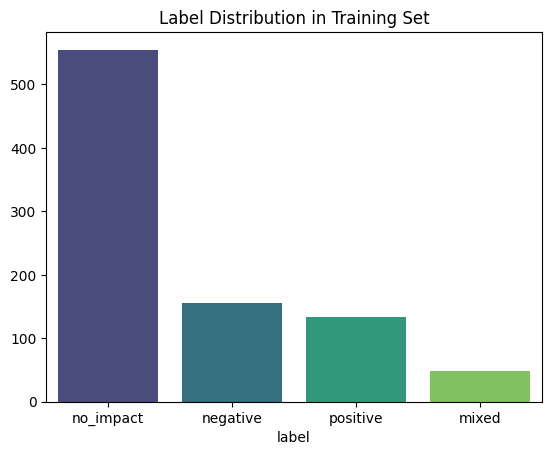

In [4]:
# Convert to DataFrame for easier manipulation
df_train = pd.DataFrame(dataset['train'])

# Plot the label distribution
label_names = ['negative', 'positive', 'no_impact', 'mixed']
df_train['label'] = df_train['label'].map({0: 'negative', 1: 'positive', 2: 'no_impact', 3: 'mixed'})
label_counts = df_train['label'].value_counts()

sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Label Distribution in Training Set')
plt.show()

### EDA

### Label Distribution in Training Set
The distribution of labels in the training set shows a significant imbalance:

- **no_impact**: The dominant class with over 500 samples.
- **negative**: Contains around 100 samples.
- **positive**: Slightly fewer than the negative class.
- **mixed**: The least frequent class with a minimal number of samples

**Text Preprocessing:** Prior to model training, thorough text preprocessing is essential to convert the `verse_text` into a suitable format for machine learning models.

**Feature Engineering:** Additional features could be engineered from the text data to enhance model performance. This could sentiment analysis scores, length of text, and frequency of key terms.

**Evaluation Metrics:** Due to the imbalance, evaluation metrics such as Precision, Recall and F1-Score should be prioritized over accuracy to ensure the model performs well across all classes.

### Explanation of the BERT Tokenizer
The BERT tokenizer is designed to preprocess text for use with BERT models. It converts raw text into a format that the BERT model can understand, specifically into token IDs, attention masks, and token type IDs. The tokenizer also adds special tokens required by the BERT model, such as `[CLS]` at the beginning of the sequence and `[SEP]` at the end.

In [5]:
# BERT Tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

# Load the BERT tokenizer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
print(tokenizer)

C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [6]:
# Example text for tokenization
first_row= dataset['train'][0]['verse_text']
print(first_row)
tokens = tokenizer.tokenize(first_row)
print(tokens)
print(tokenizer(first_row))

with pale blue berries. in these peaceful shades--
['with', 'pale', 'blue', 'berries', '.', 'in', 'these', 'peaceful', 'shades', '-', '-']
{'input_ids': [101, 2007, 5122, 2630, 22681, 1012, 1999, 2122, 9379, 13178, 1011, 1011, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [7]:
# Preprocessing function to tokenize the input texts
def preprocess_function(examples):
    return tokenizer(examples["verse_text"], truncation=True)
# ensures that if the input text is longer than what the BERT model can handle (512 tokens), it will be truncated to fit the maximum length.

In [8]:
# Applying the preprocessing function to the entire dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True) # indicates that the function should process the examples in batches, which is typically more efficient than processing one example at a time.
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 104
    })
})

* id: Unique identifier for each sample.
* verse_text: The raw text input.
* label: The sentiment classification label for the verse_text.
* input_ids: Tokenized representation of the verse_text suitable for input into the BERT model.
* token_type_ids: Segment token IDs, used for distinguishing different parts of the input; all zeros for single-sentence tasks.
* attention_mask: Binary mask to differentiate between actual tokens and padding tokens, ensuring the model only attends to meaningful parts of the input.

In [9]:
tokenized_dataset = tokenized_dataset.remove_columns(["verse_text", "id"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")
tokenized_dataset["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']



*   After tokenization, the raw text (verse_text) and unique identifier (id) may no longer be needed for model training, as the model will use the tokenized input (input_ids, token_type_ids, attention_mask) and the labels.
*   The BERT model expects the labels to be in a column named labels.
*   Setting the format to torch converts the dataset into a format compatible with PyTorch



In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Different text sequences can have different lengths. Models like BERT require all sequences in a batch to be of the same length. Instead of padding all sequences to the maximum length in the dataset (which can be inefficient), the data collator pads sequences dynamically to the length of the longest sequence in the batch.

### Explanation of the Model Design and Training Process
The model used for sentiment classification is BERT, specifically the 'bert-base-uncased' version from the Hugging Face library. This model is pre-trained on a large corpus and fine-tuned for classification task.`BertForSequenceClassification` adds a classification head on top of the BERT model.

In [11]:
# Load the BERT model for sequence classification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning message indicates that some weights in the classification head (classifier.bias and classifier.weight) are not pre-trained and need to be trained for the specific downstream task (e.g., sentiment classification). This is normal when fine-tuning a pre-trained model on a new task.

In [12]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [12]:
#command is used to set an environment variable that helps with debugging CUDA (GPU) operations in PyTorch.
#!export CUDA_LAUNCH_BLOCKING=1 

In [13]:
# Example of model work
model_inputs = tokenizer(first_row, return_tensors="pt")  # Convert the input text to PyTorch tensors
model_outputs = model(input_ids=model_inputs.input_ids, attention_mask=model_inputs.attention_mask)  # Pass the input tensors to the model
labels = ['negative', 'positive', 'no_impact', 'mixed']
model_outputs = model(**model_inputs)
print(model_inputs)
print()
print(model_outputs)
print()
print(f"Distribution over labels: {torch.softmax(model_outputs.logits, dim=1)}")  # Get the distribution over labels
print(f"Model predictions: {labels[model_outputs.logits.argmax()]}")  # Get the predicted label

{'input_ids': tensor([[  101,  2007,  5122,  2630, 22681,  1012,  1999,  2122,  9379, 13178,
          1011,  1011,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

SequenceClassifierOutput(loss=None, logits=tensor([[-0.1962,  0.3173,  0.1064, -0.2564]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Distribution over labels: tensor([[0.2014, 0.3365, 0.2725, 0.1896]], grad_fn=<SoftmaxBackward0>)
Model predictions: positive


Logits are the raw, unnormalized scores output by the final layer of a neural network before any activation function (like softmax) is applied. In the context of a classification task, logits represent the model's confidence in each class, but they are not yet probabilities.
Softmax converts logits into probabilities, making them interpretable and ensuring they sum to 1.Probabilities indicate the likelihood of each class, facilitating the selection of the most likely class as the model's prediction.

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)

    # Calculate precision
    precision = precision_score(labels, predictions, average='weighted')

    # Calculate recall
    recall = recall_score(labels, predictions, average='weighted')

    # Calculate F1-score
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

Let's  check performance of the base model without finetuning.

In [15]:
# Define evaluation arguments
eval_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    do_train=False,
    do_eval=True,
)
# Instantiate the trainer
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)
# Evaluate the raw model on the validation set
eval_result = trainer.evaluate()

# Print the evaluation results
print(eval_result)

{'eval_loss': 1.384615421295166, 'eval_accuracy': 0.1619047619047619, 'eval_precision': 0.02621315192743764, 'eval_recall': 0.1619047619047619, 'eval_f1': 0.04512099921935987, 'eval_runtime': 1.5358, 'eval_samples_per_second': 68.37, 'eval_steps_per_second': 9.116}


C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The model's performance on the validation set, without any fine-tuning, shows moderate accuracy and F1 score. This baseline performance will be used as a reference point for further fine-tuning and improvements.

### Finetuning

Let's trane model with following parametrs:
* per_device_train_batch_size Affects memory usage and training time. Smaller batch sizes require less memory but may lead to noisier gradient estimates. Larger batch sizes can take advantage of GPU parallelism but require more memory.
* logging_steps - Provides regular updates on training metrics, which can help monitor the training process closely and identify potential issues early.
* evaluation_strategy - Running evaluation at the end of each epoch allows for periodic checks on model performance, helping to prevent overfitting and to monitor validation metrics.
* metric_for_best_model - Specifies that the model achieving the highest F1 score on the validation set will be considered the best model. F1 score is a balanced metric that considers both precision and recall.
* load_best_model_at_end - Automatically loads the model with the best validation metric (based on metric_for_best_model), ensuring that the final model is the best performing one according to the specified metric.
* warmup_steps - Gradually increases the learning rate from 0 to the specified value over the first 300 steps, which can help stabilize the training process and prevent large updates at the start.
* optim="adamw_hf" - AdamW is a variant of the Adam optimizer with weight decay. It adjusts learning rates based on estimates of lower-order moments and includes weight decay for regularization. Unlike the original Adam optimizer, AdamW decouples weight decay (L2 regularization) from the gradient updates. This regularization term helps to prevent overfitting by penalizing large weights, encouraging simpler models that generalize better to new data. This is particularly important in sentiment classification where the model can easily overfit to specific words or phrases in the training data.
* adam_epsilon - A small constant added to prevent division by zero in the Adam optimizer. This parameter helps maintain numerical stability.
* adam_beta1 - Controls the exponential decay rate for the first moment estimates in the Adam optimizer. Beta1 close to 1 (e.g., 0.9) means that past gradients are discounted slowly, helping to smooth the updates.
* adam_beta2 - Controls the exponential decay rate for the second moment estimates. A value close to 1 (e.g., 0.999) means that past squared gradients are discounted slowly, helping to stabilize updates.
* callbacks - Early stopping helps prevent overfitting by halting training once the evaluation metric stops improving for a set number of epochs (early_stopping_patience). The threshold specifies the minimum change to qualify as an improvement.

In [27]:
# Define the custom logging callback
class LoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path
        os.makedirs(os.path.dirname(log_path), exist_ok=True)  # Ensure the directory exists

    def on_log(self, args, state, control, logs=None, **kwargs):
        logs = logs or {}
        logs.pop("total_flos", None)  # Optionally remove the 'total_flos' entry if it exists
        if state.is_local_process_zero:
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

In [30]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
# Define evaluation arguments
training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    per_device_train_batch_size=32,  #The batch size to use during training for each device
    per_device_eval_batch_size=32,
    logging_steps=10,                # The frequency (in steps) of logging training progress
    evaluation_strategy="epoch",     # Run validation at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
    metric_for_best_model='eval_f1', # Metric to use to select the best model
    load_best_model_at_end=True,     # Load the best model at the end of training
    learning_rate=2e-5,
    warmup_steps=300,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # The strength of weight decay (L2 regularization)
    optim="adamw_hf",                # Optimizer to use (AdamW from Hugging Face)
    adam_epsilon=1e-08,              # Epsilon parameter for the AdamW optimizer
    adam_beta1=0.9,                  # Beta1 parameter for the AdamW optimizer
    adam_beta2=0.999                 # Beta2 parameter for the AdamW optimizer
)
# Instantiate the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Add the custom logging callback
trainer.add_callback(LoggingCallback("sample_hf_trainer/log.jsonl"))

# Check if EarlyStoppingCallback is already in callbacks
if not any(isinstance(callback, EarlyStoppingCallback) for callback in trainer.callback_handler.callbacks):
    trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0))

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.585200,1.466077,0.057143,0.469565,0.057143,0.070975
2,1.354000,1.299602,0.352381,0.439977,0.352381,0.358243
3,1.253500,1.149577,0.657143,0.431837,0.657143,0.521182


C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=84, training_loss=1.4008986836387998, metrics={'train_runtime': 178.8013, 'train_samples_per_second': 14.966, 'train_steps_per_second': 0.47, 'train_loss': 1.4008986836387998, 'epoch': 3.0})

The fine-tuned model shows improvement across epochs. Training loss and validation loss decreas, indicating that the model is learning effectively. Accuracy, precision, recall, and F1 score also improve, demonstrating that the model generalizes better with each epoch of fine-tuning.

Let's increase number of training epochs to 12 and allow the model more time to learn from the data, improving its ability to capture complex patterns and relationships.
Shuffle training set samples was added to help the model generalize better to unseen data, reducing overfitting and improving validation performance. This randomness ensures that the model does not memorize the order of the data, making it more robust.

In [17]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    per_device_train_batch_size=32,  #The batch size to use during training for each device
    per_device_eval_batch_size=32,
    num_train_epochs=8,              # Number of training epochs
    logging_steps=10,                # The frequency (in steps) of logging training progress
    evaluation_strategy="epoch",     # Run validation at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
    metric_for_best_model='eval_f1', # Metric to use to select the best model
    load_best_model_at_end=True,     # Load the best model at the end of training
    learning_rate=2e-5,
    warmup_steps=300,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # The strength of weight decay (L2 regularization)
    optim="adamw_hf",                # Optimizer to use (AdamW from Hugging Face)
    adam_epsilon=1e-08,              # Epsilon parameter for the AdamW optimizer
    adam_beta1=0.9,                  # Beta1 parameter for the AdamW optimizer
    adam_beta2=0.999                 # Beta2 parameter for the AdamW optimizer
)


# Instantiate the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'].shuffle(seed=42),
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0)]
)
trainer.train()

C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.314100,1.232583,0.485714,0.529208,0.485714,0.490240
2,1.212000,1.084883,0.647619,0.429670,0.647619,0.516598
3,1.061800,0.958363,0.657143,0.431837,0.657143,0.521182
4,1.021400,0.846632,0.685714,0.625490,0.685714,0.579676
5,0.829600,0.749508,0.723810,0.643635,0.723810,0.640464
6,0.740300,0.620092,0.780952,0.652381,0.780952,0.710248
7,0.531100,0.563848,0.809524,0.834719,0.809524,0.771333
8,0.409800,0.460242,0.876190,0.875327,0.876190,0.871360
9,0.231200,0.456769,0.866667,0.865054,0.866667,0.859551
10,0.170400,0.557781,0.866667,0.867038,0.866667,0.860600


C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vlad\an

TrainOutput(global_step=308, training_loss=0.7066994723561523, metrics={'train_runtime': 694.1824, 'train_samples_per_second': 15.42, 'train_steps_per_second': 0.484, 'total_flos': 107721244844928.0, 'train_loss': 0.7066994723561523, 'epoch': 11.0})

The new fine-tuned model demonstrates significant improvements across all metrics with each epoch. Notably, the metrics see a considerable jump from epoch 5 onwards.

Let's increase batch size to 64, learning rate to 2e-4, warmup_steps to 500. The increased warmup steps can mitigate some of the risks associated with a higher learning rate, allowing for faster yet stable convergence. A larger batch size, combined with a higher learning rate and extended warmup, can lead to better generalization if the parameters are well-tuned.

In [31]:
model_lr = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
# Define evaluation arguments
training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    per_device_train_batch_size=64,  #The batch size to use during training for each device
    per_device_eval_batch_size=64,
    num_train_epochs=8,              # Number of training epochs
    logging_steps=10,                # The frequency (in steps) of logging training progress
    evaluation_strategy="epoch",     # Run validation at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
    metric_for_best_model='eval_f1', # Metric to use to select the best model
    load_best_model_at_end=True,     # Load the best model at the end of training
    learning_rate=2e-4,
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # The strength of weight decay (L2 regularization)
    optim="adamw_hf",                # Optimizer to use (AdamW from Hugging Face)
    adam_epsilon=1e-08,              # Epsilon parameter for the AdamW optimizer
    adam_beta1=0.9,                  # Beta1 parameter for the AdamW optimizer
    adam_beta2=0.999                 # Beta2 parameter for the AdamW optimizer
)
# Instantiate the trainer
trainer_lr = Trainer(
    model=model_lr,
    args=training_args,
    train_dataset=tokenized_dataset['train'].shuffle(seed=42),
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0)]
)
trainer_lr.train()

C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.313900,1.193374,0.619048,0.488095,0.619048,0.541145
2,1.238600,1.004697,0.657143,0.431837,0.657143,0.521182
3,1.022200,0.872733,0.657143,0.431837,0.657143,0.521182
4,0.928100,0.704100,0.771429,0.645185,0.771429,0.698042
5,0.693800,0.555519,0.800000,0.839402,0.800000,0.750614
6,0.464700,0.528571,0.819048,0.825974,0.819048,0.815069
7,0.355800,0.581397,0.857143,0.871655,0.857143,0.842383
8,0.204000,0.518547,0.885714,0.908208,0.885714,0.888327
9,0.151400,0.660293,0.828571,0.868788,0.828571,0.828380
10,0.108500,0.702826,0.847619,0.849784,0.847619,0.832366


C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vlad\an

TrainOutput(global_step=154, training_loss=0.5769440247253939, metrics={'train_runtime': 639.1202, 'train_samples_per_second': 16.748, 'train_steps_per_second': 0.263, 'total_flos': 117935481651936.0, 'train_loss': 0.5769440247253939, 'epoch': 11.0})

The model shows substantial improvements in all performance metrics compared to the initial base model and the previous fine-tuned model.
There are signs of overfitting in the later epochs, indicated by the increase in validation loss despite continuous reduction in training loss.

Let's add dropout layers in model and increase of weight decay to 0.02, it reduces the risk of overfitting and improve the generalization performance of  model.

In [52]:
model_dr = BertForSequenceClassification.from_pretrained('bert-base-uncased', hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1, num_labels=4)
# Define evaluation arguments
training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    per_device_train_batch_size=64,  #The batch size to use during training for each device
    per_device_eval_batch_size=64,
    num_train_epochs=8,              # Number of training epochs
    logging_steps=10,                # The frequency (in steps) of logging training progress
    evaluation_strategy="epoch",     # Run validation at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
    metric_for_best_model='eval_f1', # Metric to use to select the best model
    load_best_model_at_end=True,     # Load the best model at the end of training
    learning_rate=2e-4,
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.02,               # The strength of weight decay (L2 regularization)
    optim="adamw_hf",                # Optimizer to use (AdamW from Hugging Face)
    adam_epsilon=1e-08,              # Epsilon parameter for the AdamW optimizer
    adam_beta1=0.9,                  # Beta1 parameter for the AdamW optimizer
    adam_beta2=0.999                 # Beta2 parameter for the AdamW optimizer
)
# Instantiate the trainer
trainer_dr = Trainer(
    model=model_dr,
    args=training_args,
    train_dataset=tokenized_dataset['train'].shuffle(seed=42),
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4, early_stopping_threshold=0.0)]
)
trainer_dr.train()

C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.329300,1.235800,0.657143,0.431837,0.657143,0.521182
2,1.224400,1.068807,0.657143,0.431837,0.657143,0.521182
3,1.042600,0.910248,0.657143,0.431837,0.657143,0.521182
4,0.958200,0.786430,0.714286,0.590476,0.714286,0.641351
5,0.747900,0.667560,0.771429,0.830415,0.771429,0.730817
6,0.541400,0.505134,0.847619,0.843525,0.847619,0.843148
7,0.380900,0.408736,0.876190,0.871052,0.876190,0.871183
8,0.168900,0.569338,0.828571,0.839286,0.828571,0.830584


C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vlad\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vlad\an

TrainOutput(global_step=112, training_loss=0.7779171261936426, metrics={'train_runtime': 470.5124, 'train_samples_per_second': 15.166, 'train_steps_per_second': 0.238, 'total_flos': 85687353853920.0, 'train_loss': 0.7779171261936426, 'epoch': 8.0})

Normalization techniques improved learning process and reduced problem of overfitting. This mode shows better performance, and it is chosen for evaluation on test set. 

In [53]:
# Evaluate the model
trainer_dr.evaluate()

{'eval_loss': 0.40873590111732483,
 'eval_accuracy': 0.8761904761904762,
 'eval_precision': 0.8710522354357971,
 'eval_recall': 0.8761904761904762,
 'eval_f1': 0.8711826514643415,
 'eval_runtime': 1.5627,
 'eval_samples_per_second': 67.193,
 'eval_steps_per_second': 1.28,
 'epoch': 8.0}

In [54]:
# Generate predictions
predictions, labels, _ = trainer_dr.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=-1)

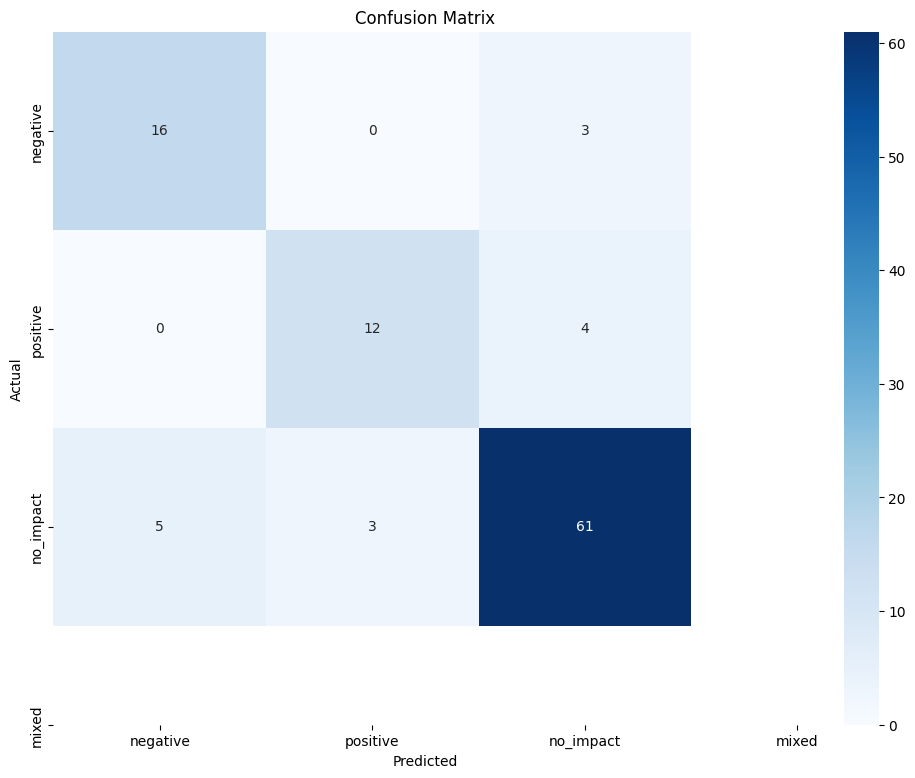

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
cm = confusion_matrix(labels, predictions)
# Plot the confusion matrix
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The model performs exceptionally well in predicting the "no impact" class with 60 true positives and minimal misclassifications.The model has moderate success in predicting the "negative" and "positive" classes, with some misclassifications into the "no impact" class.
Notably, the model does not misclassify "negative" as "positive" or vice versa, indicating clear differentiation between these classes. The model did not predict any instances as "mixed," and no actual instances of "mixed" are present in the dataset or predictions. 

In [56]:
# Error analysis: Identify misclassified samples
misclassified = np.where(predictions != labels)[0]
for i in misclassified:
    print(f"Text: {dataset['test']['verse_text'][i]}")
    print(f"Actual label: {label_names[dataset['test']['label'][i]]}, Predicted label: {label_names[predictions[i]]}")
    print()

Text: if they are hungry, paradise
Actual label: no_impact, Predicted label: positive

Text: for penance, by a saintly styrian monk
Actual label: no_impact, Predicted label: negative

Text: how hearts were answering to his own,
Actual label: positive, Predicted label: no_impact

Text: i cannot tell rude listeners
Actual label: negative, Predicted label: no_impact

Text: sings the blackened log a tune
Actual label: no_impact, Predicted label: negative

Text: midway the floor (with thatch was it strewn) burned ever the fire-flame
Actual label: no_impact, Predicted label: negative

Text: "i rather should have hewn your limbs away,
Actual label: negative, Predicted label: no_impact

Text: "is this a nightmare, or am i
Actual label: negative, Predicted label: no_impact

Text: a fleecy cloud,
Actual label: no_impact, Predicted label: negative

Text: dauntless he rose, and to the fight return’d;
Actual label: positive, Predicted label: no_impact

Text: of your strong and pliant branches,
Actu

## Summary of Error analysis

### General Hypotheses for Misclassifications
1. Subtle Sentiments:
The model may struggle with subtle sentiments that are not explicitly positive or negative. Nuanced expressions and literary language can be challenging for models to interpret correctly.
Example: "dauntless he rose, and to the fight return’d;"
Actual label: Positive
Predicted label: No_Impact
Explanation: The sentiment "dauntless" suggests positivity, but the overall context might be too subtle for the model to capture as clearly positive.

2. Context Understanding:
Misclassifications might arise from the model's difficulty in understanding the broader context of a phrase or sentence. Sentiment can depend heavily on context, which might not be fully captured by the model.
Example: "how hearts were answering to his own,"
Actual label: Positive
Predicted label: No_Impact
Explanation: Without understanding the broader context of emotional connection, the model might not recognize this as a positive sentiment.

3. Imbalanced Training Data:
If the training data has fewer examples of certain classes, the model might not learn to recognize these classes as effectively, leading to misclassifications.
Example: "shall live my highland mary."
Actual label: No_Impact
Predicted label: Positive
Explanation: If the training data has fewer examples of the "no_impact" class compared to "positive," the model might misclassify due to imbalance.

4. Complex Phrases:
Phrases with complex structure or multiple sentiments might confuse the model, leading to incorrect predictions. Literary and poetic language often contains such complexities.
Example: "for penance, by a saintly styrian monk"
Actual label: No_Impact
Predicted label: Negative
Explanation: The complex structure and mixed sentiments (penance vs. saintly) may confuse the model, leading to incorrect predictions.

5. Similar Sentiments:
Closely related sentiments, such as "no_impact" and subtle positive or negative sentiments, can be difficult to distinguish, leading to errors.
Example: "a fleecy cloud,"
Actual label: No_Impact
Predicted label: Negative
Explanation: The neutral sentiment of "fleecy cloud" might be difficult to distinguish from negative without more context.